In [2]:
import uproot
import uproot_methods
import pandas
import coffea.processor as processor
import numpy as np
from awkward import JaggedArray
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray

In [73]:
def getLorentz(x):
    objs = []
    for i in range(x['nGenDressedLepton']):
        objs.append(LorentzVectorWID(x['GenDressedLepton_pt'][i], 
                                        x['GenDressedLepton_eta'][i],
                                        x['GenDressedLepton_phi'][i],
                                        x['GenDressedLepton_mass'][i], 
                                        x['GenDressedLepton_pdgId'][i],
            )
        )
    return objs

In [220]:
import itertools
def bestMass(x):
    bestMass = 1000
    pair = (1,2)
    for i,j in itertools.combinations([1,2,3], 2):
        if (x["lep%i"%i].getPdgId()+x["lep%i" % j].getPdgId() == 0):
            comp = (x["lep%i" % i].getP4() + x["lep%i" % j].getP4()).mass
            #comp = x["lep%i" % i].p4().mass
            if comp < bestMass:
                bestMass = comp
                pair = (i,j)
    return pair

In [210]:
class LorentzVectorWID:
    def __init__(self, pt, eta, phi, m, pdgId):
        self.pdgId = pdgId
        self.p4 = uproot_methods.TLorentzVector.from_ptetaphim(pt, eta, phi, m)
    def getPdgId(self):
        return self.pdgId
    def getP4(self):
        return self.p4
    def __str__(self):
        return "%i; %0.2f, %0.2f, %0.2f, %0.2f" % (self.pdgId, self.p4.pt, self.p4.eta, self.p4.phi, self.p4.mass)
    def __repr__(self):
        return __str__(self)

In [193]:
ewwz_file = uproot.open("Data/EWWZ_Nano/B0717A4C-F989-444A-BA62-304785265E1C.root")

In [194]:
readvars = ["*GenDressedLepton*", "GenMET*"]
tree = ewwz_file['Events']

In [195]:
pandas_df = tree.pandas.df(readvars, flatten=False)

In [196]:
df = pandas_df[pandas_df.nGenDressedLepton==3]

In [212]:
pandas.options.mode.chained_assignment = None
df["leps"] = df.apply(lambda x: getLorentz(x), axis=1)

In [213]:
for i in range(3):
    df["lep%i" %(i+1)] = df["leps"].apply(lambda x: x[i])
filtered_df = df.drop(["nGenDressedLepton", "GenDressedLepton_pt", "GenDressedLepton_eta", "GenDressedLepton_phi", "GenDressedLepton_mass", "leps"], axis=1)
filtered_df

,GenDressedLepton_pdgId,GenDressedLepton_hasTauAnc,GenMET_phi,GenMET_pt,lep1,lep2,lep3
entry,,,,,,,
7,"[-13, -11, 11]","[False, False, False]",0.220581,48.156250,"-13; 82.36, -1.22, -1.09, 0.11","-11; 80.48, -1.52, 2.94, 0.00","11; 20.69, -2.25, -2.72, 0.00"
11,"[-11, -13, 11]","[False, False, False]",2.304688,20.875000,"-11; 147.50, -0.68, -2.94, 0.00","-13; 137.34, -0.99, -2.43, 0.11","11; 46.11, -1.65, 3.13, 0.00"
20,"[11, -11, 11]","[False, False, False]",-2.996094,315.500000,"11; 104.53, 0.92, 1.01, 0.00","-11; 84.59, 1.57, 0.15, 0.00","11; 60.52, -0.81, 2.82, 0.00"
25,"[-11, -11, 11]","[False, False, False]",-2.488281,8.789062,"-11; 56.01, 1.77, -1.46, 0.00","-11; 53.06, -0.66, -0.55, 0.06","11; 33.92, 0.58, -2.60, 0.10"
26,"[11, -11, -13]","[False, False, False]",-0.894043,75.750000,"11; 70.63, -0.80, 2.32, 0.00","-11; 46.17, -2.22, 2.57, 0.00","-13; 22.54, 0.27, 2.80, 0.11"
...,...,...,...,...,...,...,...
17988,"[11, 13, -13]","[False, False, False]",-1.226562,112.375000,"11; 134.97, -0.61, -1.78, 0.00","13; 71.04, -0.70, -0.49, 0.11","-13; 42.53, -0.25, -2.34, 0.11"
17989,"[-11, -13, 11]","[False, False, False]",-2.453125,27.515625,"-11; 140.97, 0.37, 0.05, 0.65","-13; 44.22, -0.59, 1.39, 0.64","11; 17.04, 0.36, -2.31, 0.05"
17997,"[-11, -13, 11]","[False, False, False]",2.558594,79.687500,"-11; 105.55, 1.19, 0.91, 0.00","-13; 34.95, -0.87, -2.14, 0.11","11; 21.92, 2.35, -0.76, 0.00"


In [221]:
filtered_df["massIndices"] = filtered_df.apply(lambda x: bestMass(x), axis=1)
filtered_df

,GenDressedLepton_pdgId,GenDressedLepton_hasTauAnc,GenMET_phi,GenMET_pt,lep1,lep2,lep3,massIndices
entry,,,,,,,,
7,"[-13, -11, 11]","[False, False, False]",0.220581,48.156250,"-13; 82.36, -1.22, -1.09, 0.11","-11; 80.48, -1.52, 2.94, 0.00","11; 20.69, -2.25, -2.72, 0.00","(2, 3)"
11,"[-11, -13, 11]","[False, False, False]",2.304688,20.875000,"-11; 147.50, -0.68, -2.94, 0.00","-13; 137.34, -0.99, -2.43, 0.11","11; 46.11, -1.65, 3.13, 0.00","(1, 3)"
20,"[11, -11, 11]","[False, False, False]",-2.996094,315.500000,"11; 104.53, 0.92, 1.01, 0.00","-11; 84.59, 1.57, 0.15, 0.00","11; 60.52, -0.81, 2.82, 0.00","(1, 2)"
25,"[-11, -11, 11]","[False, False, False]",-2.488281,8.789062,"-11; 56.01, 1.77, -1.46, 0.00","-11; 53.06, -0.66, -0.55, 0.06","11; 33.92, 0.58, -2.60, 0.10","(1, 3)"
26,"[11, -11, -13]","[False, False, False]",-0.894043,75.750000,"11; 70.63, -0.80, 2.32, 0.00","-11; 46.17, -2.22, 2.57, 0.00","-13; 22.54, 0.27, 2.80, 0.11","(1, 2)"
...,...,...,...,...,...,...,...,...
17988,"[11, 13, -13]","[False, False, False]",-1.226562,112.375000,"11; 134.97, -0.61, -1.78, 0.00","13; 71.04, -0.70, -0.49, 0.11","-13; 42.53, -0.25, -2.34, 0.11","(2, 3)"
17989,"[-11, -13, 11]","[False, False, False]",-2.453125,27.515625,"-11; 140.97, 0.37, 0.05, 0.65","-13; 44.22, -0.59, 1.39, 0.64","11; 17.04, 0.36, -2.31, 0.05","(1, 3)"
17997,"[-11, -13, 11]","[False, False, False]",2.558594,79.687500,"-11; 105.55, 1.19, 0.91, 0.00","-13; 34.95, -0.87, -2.14, 0.11","11; 21.92, 2.35, -0.76, 0.00","(1, 3)"


In [222]:
filtered_df["zCand"] = filtered_df.apply(lambda x: x["lep%i" % x["massIndices"][0]].getP4() + x["lep%i" % x["massIndices"][1]].getP4(), axis=1)

In [258]:
data = filtered_df
data["Zlep1"] = data.apply(lambda x: max(x["lep%i" % x["massIndices"][0]], x["lep%i" % x["massIndices"][1]], key=lambda x: x.getP4().pt), axis=1)
data["Zlep2"] = data.apply(lambda x: min(x["lep%i" % x["massIndices"][0]], x["lep%i" % x["massIndices"][1]], key=lambda x: x.getP4().pt), axis=1)
data["Wlep"] = data.apply(lambda x: x["lep%i" % (set([1,2,3])^set(x["massIndices"])).pop()], axis=1)

In [259]:
data

,GenDressedLepton_pdgId,GenDressedLepton_hasTauAnc,GenMET_phi,GenMET_pt,lep1,lep2,lep3,massIndices,zCand,Zlep1,Zlep2,Wlep
entry,,,,,,,,,,,,
7,"[-13, -11, 11]","[False, False, False]",0.220581,48.156250,"-13; 82.36, -1.22, -1.09, 0.11","-11; 80.48, -1.52, 2.94, 0.00","11; 20.69, -2.25, -2.72, 0.00","(2, 3)","TLorentzVector(-97.722, 7.4288, -272.47, 292.23)","-11; 80.48, -1.52, 2.94, 0.00","11; 20.69, -2.25, -2.72, 0.00","-13; 82.36, -1.22, -1.09, 0.11"
11,"[-11, -13, 11]","[False, False, False]",2.304688,20.875000,"-11; 147.50, -0.68, -2.94, 0.00","-13; 137.34, -0.99, -2.43, 0.11","11; 46.11, -1.65, 3.13, 0.00","(1, 3)","TLorentzVector(-190.5, -29.567, -224.22, 307.52)","-11; 147.50, -0.68, -2.94, 0.00","11; 46.11, -1.65, 3.13, 0.00","-13; 137.34, -0.99, -2.43, 0.11"
20,"[11, -11, 11]","[False, False, False]",-2.996094,315.500000,"11; 104.53, 0.92, 1.01, 0.00","-11; 84.59, 1.57, 0.15, 0.00","11; 60.52, -0.81, 2.82, 0.00","(1, 2)","TLorentzVector(139.3, 101.2, 306.48, 365.47)","11; 104.53, 0.92, 1.01, 0.00","-11; 84.59, 1.57, 0.15, 0.00","11; 60.52, -0.81, 2.82, 0.00"
25,"[-11, -11, 11]","[False, False, False]",-2.488281,8.789062,"-11; 56.01, 1.77, -1.46, 0.00","-11; 53.06, -0.66, -0.55, 0.06","11; 33.92, 0.58, -2.60, 0.10","(1, 3)","TLorentzVector(-22.953, -73.204, 181.26, 209.68)","-11; 56.01, 1.77, -1.46, 0.00","11; 33.92, 0.58, -2.60, 0.10","-11; 53.06, -0.66, -0.55, 0.06"
26,"[11, -11, -13]","[False, False, False]",-0.894043,75.750000,"11; 70.63, -0.80, 2.32, 0.00","-11; 46.17, -2.22, 2.57, 0.00","-13; 22.54, 0.27, 2.80, 0.11","(1, 2)","TLorentzVector(-87.27, 76.309, -272.21, 309.1)","11; 70.63, -0.80, 2.32, 0.00","-11; 46.17, -2.22, 2.57, 0.00","-13; 22.54, 0.27, 2.80, 0.11"
...,...,...,...,...,...,...,...,...,...,...,...,...
17988,"[11, 13, -13]","[False, False, False]",-1.226562,112.375000,"11; 134.97, -0.61, -1.78, 0.00","13; 71.04, -0.70, -0.49, 0.11","-13; 42.53, -0.25, -2.34, 0.11","(2, 3)","TLorentzVector(33.113, -64.364, -64.869, 133.16)","13; 71.04, -0.70, -0.49, 0.11","-13; 42.53, -0.25, -2.34, 0.11","11; 134.97, -0.61, -1.78, 0.00"
17989,"[-11, -13, 11]","[False, False, False]",-2.453125,27.515625,"-11; 140.97, 0.37, 0.05, 0.65","-13; 44.22, -0.59, 1.39, 0.64","11; 17.04, 0.36, -2.31, 0.05","(1, 3)","TLorentzVector(129.22, -4.8649, 60.266, 169.12)","-11; 140.97, 0.37, 0.05, 0.65","11; 17.04, 0.36, -2.31, 0.05","-13; 44.22, -0.59, 1.39, 0.64"
17997,"[-11, -13, 11]","[False, False, False]",2.558594,79.687500,"-11; 105.55, 1.19, 0.91, 0.00","-13; 34.95, -0.87, -2.14, 0.11","11; 21.92, 2.35, -0.76, 0.00","(1, 3)","TLorentzVector(80.95, 68.046, 271.67, 305.89)","-11; 105.55, 1.19, 0.91, 0.00","11; 21.92, 2.35, -0.76, 0.00","-13; 34.95, -0.87, -2.14, 0.11"


In [276]:
data = data[data.apply(lambda x: (x.Zlep1.getP4().pt > 20) & (x.Zlep2.getP4().pt > 20) & (x.Wlep.getP4().pt > 20) & (x.zCand.mass < 106) & (x.zCand.mass > 76), axis=1)]
data

,GenDressedLepton_pdgId,GenDressedLepton_hasTauAnc,GenMET_phi,GenMET_pt,lep1,lep2,lep3,massIndices,zCand,Zlep1,Zlep2,Wlep
entry,,,,,,,,,,,,
11,"[-11, -13, 11]","[False, False, False]",2.304688,20.875000,"-11; 147.50, -0.68, -2.94, 0.00","-13; 137.34, -0.99, -2.43, 0.11","11; 46.11, -1.65, 3.13, 0.00","(1, 3)","TLorentzVector(-190.5, -29.567, -224.22, 307.52)","-11; 147.50, -0.68, -2.94, 0.00","11; 46.11, -1.65, 3.13, 0.00","-13; 137.34, -0.99, -2.43, 0.11"
20,"[11, -11, 11]","[False, False, False]",-2.996094,315.500000,"11; 104.53, 0.92, 1.01, 0.00","-11; 84.59, 1.57, 0.15, 0.00","11; 60.52, -0.81, 2.82, 0.00","(1, 2)","TLorentzVector(139.3, 101.2, 306.48, 365.47)","11; 104.53, 0.92, 1.01, 0.00","-11; 84.59, 1.57, 0.15, 0.00","11; 60.52, -0.81, 2.82, 0.00"
26,"[11, -11, -13]","[False, False, False]",-0.894043,75.750000,"11; 70.63, -0.80, 2.32, 0.00","-11; 46.17, -2.22, 2.57, 0.00","-13; 22.54, 0.27, 2.80, 0.11","(1, 2)","TLorentzVector(-87.27, 76.309, -272.21, 309.1)","11; 70.63, -0.80, 2.32, 0.00","-11; 46.17, -2.22, 2.57, 0.00","-13; 22.54, 0.27, 2.80, 0.11"
28,"[-11, -13, 11]","[False, True, False]",2.662109,30.562500,"-11; 49.50, 0.15, -0.10, 0.00","-13; 44.60, -0.01, -1.09, 0.11","11; 38.65, 1.03, -3.00, 0.00","(1, 3)","TLorentzVector(10.974, -10.418, 54.715, 111.05)","-11; 49.50, 0.15, -0.10, 0.00","11; 38.65, 1.03, -3.00, 0.00","-13; 44.60, -0.01, -1.09, 0.11"
37,"[-13, 13, -11]","[False, False, False]",2.611328,76.562500,"-13; 107.83, 0.91, -2.89, 0.11","13; 31.97, -0.44, 2.92, 0.11","-11; 23.81, -0.99, -0.79, 0.00","(1, 2)","TLorentzVector(-135.61, -19.71, 97.998, 191.15)","-13; 107.83, 0.91, -2.89, 0.11","13; 31.97, -0.44, 2.92, 0.11","-11; 23.81, -0.99, -0.79, 0.00"
...,...,...,...,...,...,...,...,...,...,...,...,...
17986,"[-13, 11, 13]","[False, False, False]",3.017578,22.765625,"-13; 71.78, -0.06, 2.16, 0.11","11; 71.01, 0.82, -2.36, 0.00","13; 26.90, -0.82, -0.89, 0.11","(1, 3)","TLorentzVector(-22.865, 38.855, -29.038, 108.31)","-13; 71.78, -0.06, 2.16, 0.11","13; 26.90, -0.82, -0.89, 0.11","11; 71.01, 0.82, -2.36, 0.00"
17987,"[11, 13, -13]","[False, False, False]",1.840820,60.031250,"11; 91.02, -0.33, 2.12, 0.00","13; 77.12, -0.15, -2.45, 0.11","-13; 51.54, 0.25, -0.91, 0.11","(2, 3)","TLorentzVector(-27.662, -89.819, 1.7056, 131.12)","13; 77.12, -0.15, -2.45, 0.11","-13; 51.54, 0.25, -0.91, 0.11","11; 91.02, -0.33, 2.12, 0.00"
17988,"[11, 13, -13]","[False, False, False]",-1.226562,112.375000,"11; 134.97, -0.61, -1.78, 0.00","13; 71.04, -0.70, -0.49, 0.11","-13; 42.53, -0.25, -2.34, 0.11","(2, 3)","TLorentzVector(33.113, -64.364, -64.869, 133.16)","13; 71.04, -0.70, -0.49, 0.11","-13; 42.53, -0.25, -2.34, 0.11","11; 134.97, -0.61, -1.78, 0.00"


In [278]:
import matplotlib.pyplot as plt

(array([  60.,   87.,  117.,  228., 1132., 1374.,  225.,   78.,   40.,
          30.]), array([ 76.00662488,  78.98909993,  81.97157497,  84.95405001,
         87.93652506,  90.9190001 ,  93.90147514,  96.88395019,
         99.86642523, 102.84890028, 105.83137532]), <a list of 10 Patch objects>)

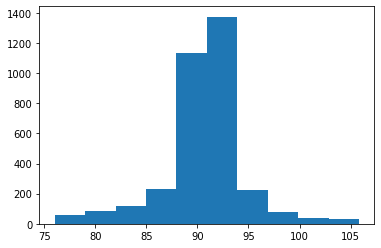

In [282]:
plt.hist(data.apply(lambda x: x['zCand'].mass, axis=1))

In [254]:
[str(i) for i in set([1,2,3])^set([1,2])]

['3']

In [250]:
unique([1,2,3], [1,2])

NameError: name 'unique' is not defined

In [256]:
x = set([1,2])

In [257]:
x.pop()

1